In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data with mean and std of the MNIST dataset
])

In [27]:
# Load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # 28 X 28 X 1  -> 14 X 14 X 32
        x = self.pool(self.relu(self.conv2(x)))   # 14 X 14 X 32 -> 7 X 7 X 64
        x = x.view(-1, 64 * 7 * 7)                # Flattening: batch_size X 7 X 7 X 64 -> batch_size X (7*7*64)
        x = self.relu(self.fc1(x))                # FC: 7*7*64, 128
        x = self.dropout(x)                       # Dropout: 0.5
        x = self.fc2(x)                           # FC: 128, 10
        return x

In [13]:
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [14]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Train the Model
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

In [16]:
# Test the model
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [17]:
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_accuracy = test(model, test_dataloader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.2399, Train Accuracy: 92.58%, Test Loss: 0.0442, Test Accuracy: 98.49%
Epoch [2/10], Train Loss: 0.0838, Train Accuracy: 97.57%, Test Loss: 0.0285, Test Accuracy: 99.04%
Epoch [3/10], Train Loss: 0.0636, Train Accuracy: 98.16%, Test Loss: 0.0296, Test Accuracy: 99.02%
Epoch [4/10], Train Loss: 0.0525, Train Accuracy: 98.44%, Test Loss: 0.0245, Test Accuracy: 99.20%
Epoch [5/10], Train Loss: 0.0437, Train Accuracy: 98.70%, Test Loss: 0.0242, Test Accuracy: 99.26%
Epoch [6/10], Train Loss: 0.0380, Train Accuracy: 98.83%, Test Loss: 0.0241, Test Accuracy: 99.23%
Epoch [7/10], Train Loss: 0.0334, Train Accuracy: 98.96%, Test Loss: 0.0290, Test Accuracy: 99.13%
Epoch [8/10], Train Loss: 0.0272, Train Accuracy: 99.16%, Test Loss: 0.0276, Test Accuracy: 99.24%
Epoch [9/10], Train Loss: 0.0289, Train Accuracy: 99.09%, Test Loss: 0.0227, Test Accuracy: 99.40%
Epoch [10/10], Train Loss: 0.0228, Train Accuracy: 99.30%, Test Loss: 0.0226, Test Accuracy: 99.31%


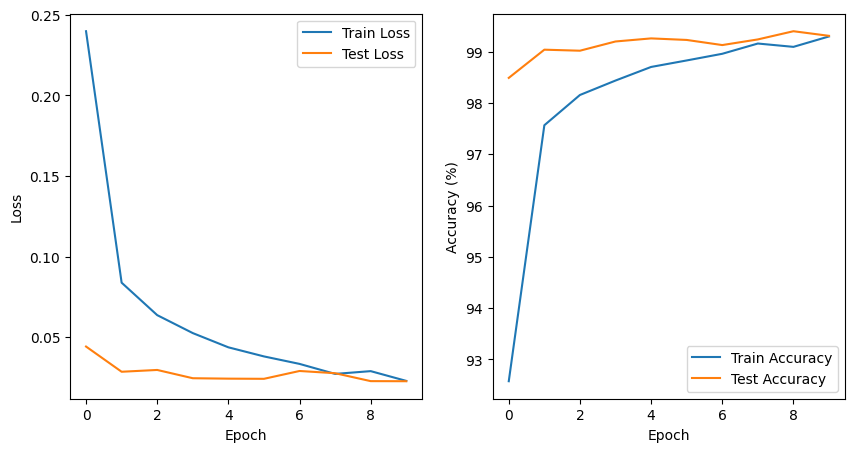

In [18]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()